In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
from scipy import stats

plt.style.use("seaborn-v0_8")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.getcwd()

'/home/anyone/autonomous_f1tenth/src/perception/perception/scripts'

In [9]:
run_dir = '/home/anyone/autonomous_f1tenth/perception_debug/24_09_14_15:38:17'
csv_path = f'{run_dir}/bev/ego_poses.csv'
start_time = int(np.loadtxt(f'{run_dir}/start_time.txt')) / 1e9

df = pd.read_csv(csv_path)
# convert to nanoseconds
df["time (sec)"] = df["time"] / 1e9
df

,time,qx,qy,qz,qw,tx,ty,tz,time (sec)
0,1726285099852989670,-0.277582,0.960529,0.017371,-0.005549,1.827983,1.477797,2.981099,1.726285e+09
1,1726285099862146120,-0.277637,0.960554,0.015200,-0.004681,1.828541,1.478126,2.981718,1.726285e+09
2,1726285099874155780,-0.275534,0.961137,0.017097,-0.002099,1.834158,1.482445,2.990534,1.726285e+09
3,1726285099890593597,-0.275825,0.960973,0.020765,-0.004488,1.831266,1.480235,2.986529,1.726285e+09
4,1726285099907478446,-0.279381,0.960068,0.013266,-0.006304,1.824048,1.474876,2.974645,1.726285e+09
...,...,...,...,...,...,...,...,...,...
431,1726285107557842625,-0.024733,0.999659,0.002308,-0.008041,0.152219,1.230782,2.957703,1.726285e+09
432,1726285107574148355,-0.024772,0.999649,-0.001800,-0.009268,0.152312,1.231907,2.960168,1.726285e+09
433,1726285107590771676,-0.024811,0.999667,0.001600,-0.006970,0.152130,1.230977,2.957574,1.726285e+09
434,1726285107607502939,-0.022939,0.999596,0.014400,-0.008652,0.151023,1.223135,2.938723,1.726285e+09


In [10]:
# Include a few frames before the trajectory start time
window_before_start_time = 1
df_start_time = df[df["time (sec)"] > start_time]
first_index = df_start_time.index.min()

if window_before_start_time >= 1:
    df_start_time = pd.concat([df.iloc[first_index - window_before_start_time:first_index], df_start_time])

df_start_time = df_start_time.reset_index(drop=True)

# normalise the time from df to start at 0
df_start_time['time_norm (sec)'] = (df_start_time['time (sec)'] - start_time)
df_start_time

,time,qx,qy,qz,qw,tx,ty,tz,time (sec),time_norm (sec)
0,1726285102840529377,-0.279827,0.959777,0.020706,0.009840,1.832153,1.482289,2.987058,1.726285e+09,-0.008230
1,1726285102857275766,-0.274425,0.961497,0.014474,0.002085,1.839067,1.486145,2.998801,1.726285e+09,0.008516
2,1726285102874043468,-0.274992,0.961271,0.018235,-0.002383,1.834755,1.483148,2.992533,1.726285e+09,0.025284
3,1726285102891676983,-0.276096,0.960984,0.016393,-0.003547,1.830302,1.479902,2.985285,1.726285e+09,0.042917
4,1726285102908531798,-0.277936,0.960463,0.014979,-0.006086,1.827337,1.477380,2.979541,1.726285e+09,0.059772
...,...,...,...,...,...,...,...,...,...,...
254,1726285107557842625,-0.024733,0.999659,0.002308,-0.008041,0.152219,1.230782,2.957703,1.726285e+09,4.709083
255,1726285107574148355,-0.024772,0.999649,-0.001800,-0.009268,0.152312,1.231907,2.960168,1.726285e+09,4.725389
256,1726285107590771676,-0.024811,0.999667,0.001600,-0.006970,0.152130,1.230977,2.957574,1.726285e+09,4.742012
257,1726285107607502939,-0.022939,0.999596,0.014400,-0.008652,0.151023,1.223135,2.938723,1.726285e+09,4.758743


In [11]:
# get numerical values of outliers
q1 = df_start_time['tx'].quantile(0.25)

z_tx: pd.Series = stats.zscore(df_start_time['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(df_start_time['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(df_start_time['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
df_start_time.iloc[outliers]

,time,qx,qy,qz,qw,tx,ty,tz,time (sec),time_norm (sec)
33,1726285103407088995,-0.202658,0.789422,-0.255654,0.519984,1.722074,1.440730,3.045199,1.726285e+09,0.558329
92,1726285104822558890,-0.022856,0.997496,0.058509,-0.032496,0.854320,1.184029,2.791463,1.726285e+09,1.973799


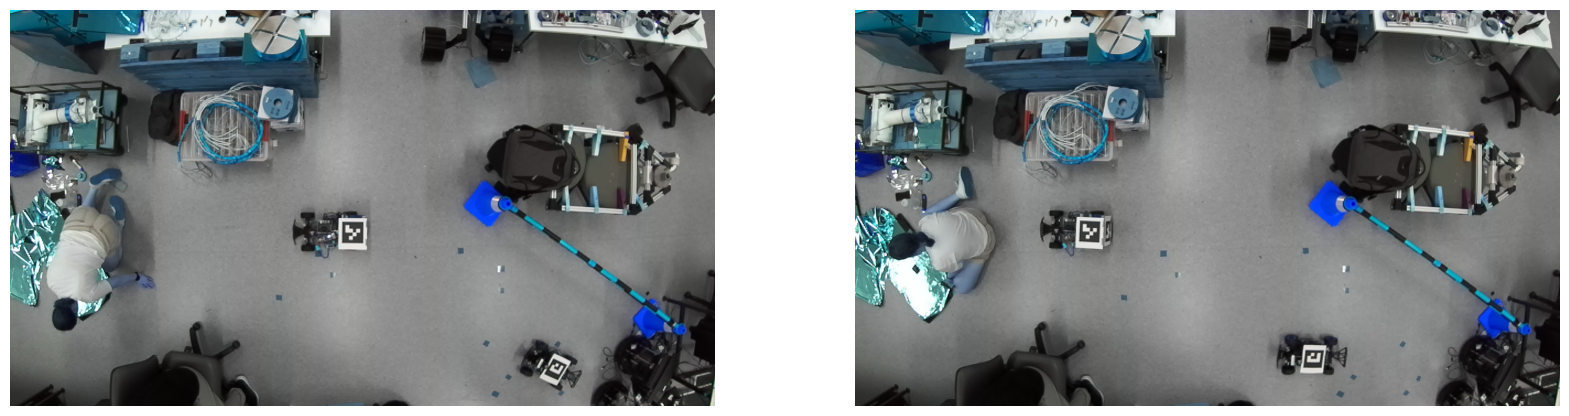

In [15]:
import math
plt.figure(figsize=(20, 20))
grid_size = math.ceil(math.sqrt(len(df_start_time.iloc[outliers])))
for i, entry in enumerate(df_start_time.iloc[outliers]["time"]):
    plt.subplot(grid_size, grid_size, i+1)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(cv2.imread(f'{run_dir}/bev/right/{entry}.png'))

In [39]:
df_proc = df_start_time.drop(outliers)
df_proc = df_start_time.sort_values(by='time_norm', ascending=True)
df_proc.describe()

,index,time,qx,qy,qz,qw,tx,ty,tz,time_norm
count,258.000000,2.580000e+02,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,2.580000e+02
mean,306.500000,1.726285e+18,-0.077210,0.974760,-0.029242,0.027334,0.736467,1.273244,2.938214,2.479090e+09
std,74.622383,1.402653e+09,0.090983,0.050997,0.131165,0.119838,0.608323,0.079799,0.035411,1.402653e+09
min,178.000000,1.726285e+18,-0.288492,0.741414,-0.463153,-0.074876,0.144493,1.184029,2.791463,0.000000e+00
25%,242.250000,1.726285e+18,-0.133518,0.971845,0.004530,-0.012782,0.152222,1.226412,2.920327,1.278758e+09
50%,306.500000,1.726285e+18,-0.022918,0.998626,0.015017,-0.007074,0.538910,1.236987,2.941059,2.575087e+09
75%,370.750000,1.726285e+18,-0.020299,0.999609,0.028346,-0.000753,1.282781,1.276421,2.953915,3.688850e+09
max,435.000000,1.726285e+18,0.008391,0.999759,0.073566,0.583740,1.839067,1.486513,3.045199,4.766773e+09


In [88]:
from numpy.polynomial.polynomial import Polynomial

degree = 5
tx_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['tx'], degree)
ty_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['ty'], degree)
tz_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['tz'], degree)

In [89]:
tx_preds = tx_model(df_proc['time_norm'])
ty_preds = ty_model(df_proc['time_norm'])
tz_preds = tz_model(df_proc['time_norm'])

tx_residuals = df_proc['tx'] - tx_preds
ty_residuals = df_proc['ty'] - ty_preds
tz_residuals = df_proc['tz'] - tz_preds

confidence = 0.95
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - confidence) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence

0.041682781010589864

<AxesSubplot: xlabel='time_norm'>

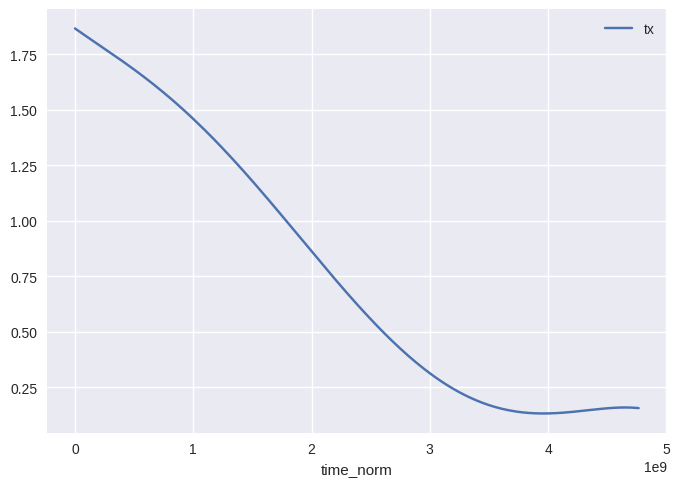

In [90]:
pd.DataFrame((np.vstack((df_proc["time_norm"].values, tx_model(df_proc["time_norm"]))).T), columns=["time_norm", "tx"]).plot(x="time_norm", y="tx")

<AxesSubplot: xlabel='time_norm', ylabel='tz'>

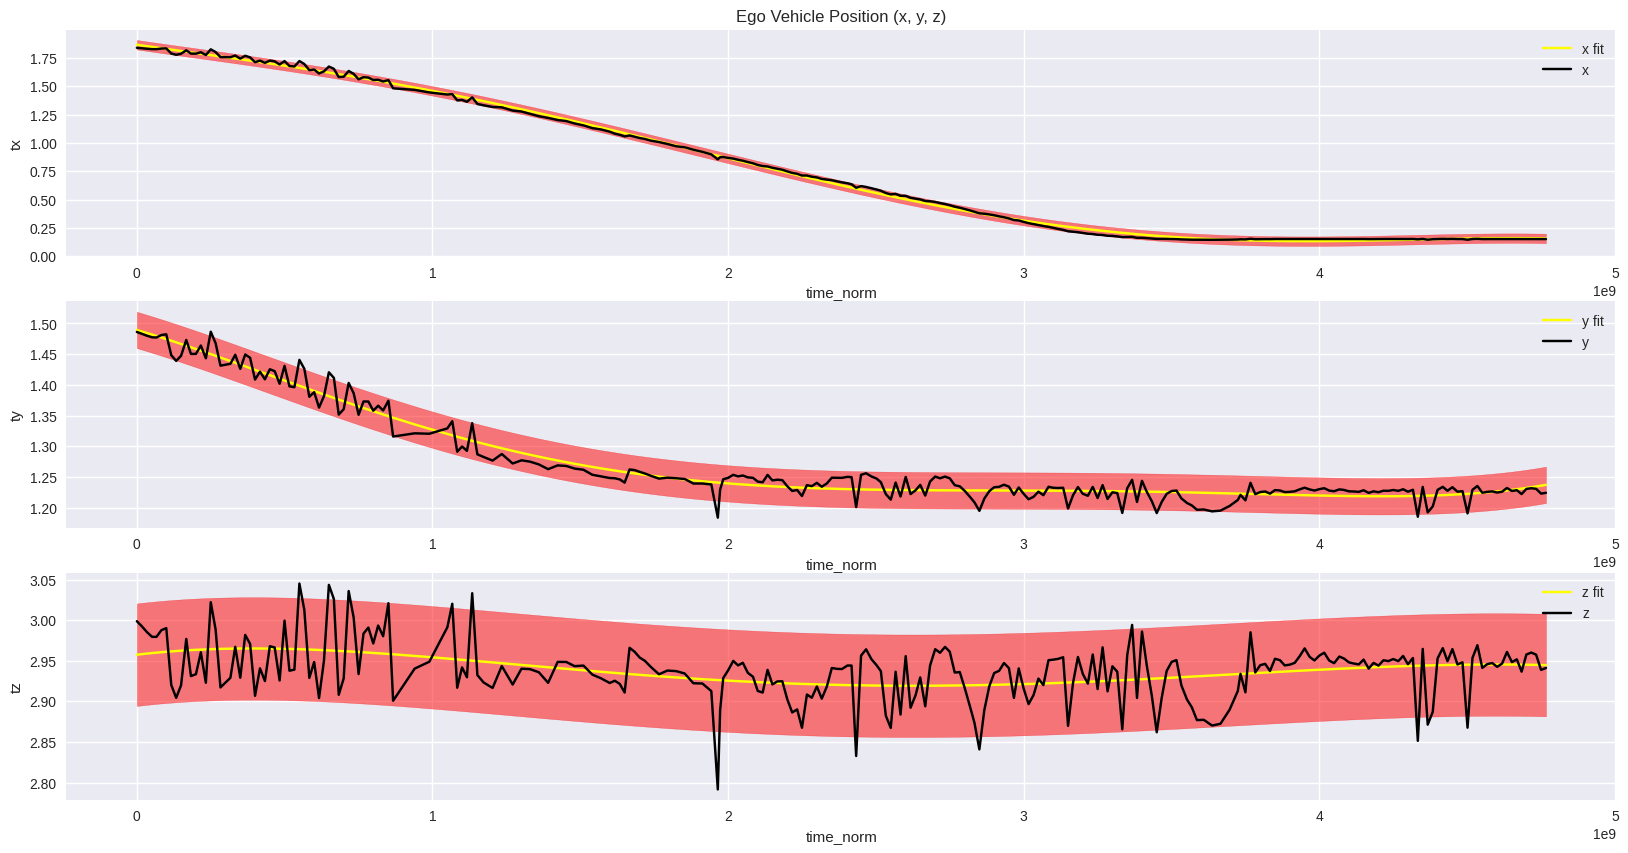

In [91]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# plot the polynomial fit
plt.plot(df_proc['time_norm'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(df_proc['time_norm'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=df_proc, x='time_norm', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(df_proc['time_norm'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(df_proc['time_norm'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=df_proc, x='time_norm', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(df_proc['time_norm'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(df_proc['time_norm'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=df_proc, x='time_norm', y='tz', label='z', color='black')